# Paper experiment runs

We obtained [hg19](http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/chromFa.tar.gz) and [mm8](http://hgdownload.cse.ucsc.edu/goldenpath/mm8/bigZips/chromFa.tar.gz) genomes from UCSC. Then we filtered out all `_random` and `unGl` chromosomes and patches from the final FASTA file. We used [hg19 WGAC calls](http://humanparalogy.gs.washington.edu/build37/data/GRCh37GenomicSuperDup.tab) and [mm8 WGAC calls](http://mouseparalogy.gs.washington.edu/She2008_download/WGAC.tab.gz) to compare SEDEF with WGAC.

SEDEF ([release v1.1, git commit e603a5c](https://github.com/vpc-ccg/sedef/tree/1.1)) was run as follows:

In [1]:
!./sedef.sh -f -o out/hg19_final -j 80 genome/hg19.fa -w wgac/GRCh37GenomicSuperDup.tab

Start: Tue Mar 27 14:03:48 PDT 2018
************************************************************************
SEDEF: FASTA=genome/hg19.fa; output=out/hg19_final; jobs=80; force=y
************************************************************************
Running SD seeding...
Seeding time: 9:35.32
SD seeding done: done running 600 jobs!
Single-core running time: 11 hours (41359.2 seconds)
Memory used: 4888 MB
************************************************************************
Running SD alignment...
Aligning time: 4:16.41
SD alignment done: finished 1000 jobs!
Single-core running time: 5 hours (18742.5 seconds)
Memory used: 7070 MB
************************************************************************
Running SD reporting...
Processed hit 184,021 out of 184,021... done!
Report time: 0:05.67 (758,872 MB, user 164.57)
Line counts:
   186400 out/hg19_final/aligned.bed
    67882 out/hg19_final/final.bed
  2248064 out/hg19_final/potentials.bed
  2363898 out/hg19_final/seeds.bed
*********

In [2]:
!./sedef.sh -f -o out/mm8_final -j 80 genome/mm8.fa -w wgac/WGAC.tab

Start: Tue Mar 27 14:24:35 PDT 2018
************************************************************************
SEDEF: FASTA=genome/mm8.fa; output=out/mm8_final; jobs=80; force=y
************************************************************************
Running SD seeding...
Seeding time: 10:20.74
SD seeding done: done running 462 jobs!
Single-core running time: 11 hours (40755.5 seconds)
Memory used: 2925 MB
************************************************************************
Running SD alignment...
Aligning time: 11:59.20
SD alignment done: finished 1000 jobs!
Single-core running time: 9 hours (35133.5 seconds)
Memory used: 7048 MB
************************************************************************
Running SD reporting...
Read 887,924 hits, wrote 0 SDs
Report time: 1:47.61 (1874456 MB, user 825.22)
   887924 out/mm8_final/aligned.bed
   352991 out/mm8_final/final.bed
  3215554 out/mm8_final/potentials.bed
  3453215 out/mm8_final/seeds.bed
*****************************************

With default parameters (used in the paper), indexing k-mer size is 11, while seeding k-mer size is 12.

Our script automatically compares SEDEF's results with WGAC (by passing WGAC file with `-w` parameter). The final calls are reported in `final.bed`, and SDs within this file were used for generating benchmark and comparison statistics. Timings were calculated by substracting `Start` and `End` timestamps (WGAC comparison was not timed).

### Filtering spurious misses

Since WGAC data contains many questinable calls, we filter out all calls which fail SEDEF's quality filters (e.g. number of uppercase letters, length etc) to make the comparison fair. In order to run this, you will need [SEDEF v1.1](https://github.com/vpc-ccg/sedef/tree/1.1) that was used to generate paper results (clean-up module, a.k.a. `wgac manual`, was removed in later versions).

In the following command, WGAC data is stored in `WGAC_hg19.tab`, while SEDEF calls (used for generating WGAC calls that SEDEF cannot detect) are in `hg19/final.bed` (same for `mm8`). Note that file `final.misses.txt` is generated by `sedef.sh` if you pass it `-w` parameter as specified above.

```bash
for G in hg19 mm8 ; do
    # Generate BED and alignments for WGAC miss entries
    ./sedef wgac manual $G.fa x < $G/final.misses.txt > temp 
    # Run QC on these misses
    ./sedef stats generate $G.fa temp |\
        sort -k1,1V -k9,9r -k10,10r -k4,4V -k2,2n -k3,3n -k5,5n -k6,6n |\
        uniq > $G.misses
    # Count number of misses which passed QC
    echo -ne $G" "; wc -l $G.misses
done
# Expected output:
# hg19 47 hg19.misses
# mm8 1992 mm8.misses
```

As can be seen, SEDEF misses for real only 1,992 SDs from mm8 (all other "misses" are filtered by quality control during `stats generate`.

## Comparison with other tools (hg19)

Final calls of these tools are [available here](http://cb.csail.mit.edu/cb/sedef/other.tar.gz).

### Minimap2

[Minimap2 b81d455](https://github.com/lh3/minimap2/commit/b81d45510ef998762d7084eae93044d85c0a3b8a) was run as follows:

```bash
# Run minimap2
for i in `seq 1 22` X Y; do for j in `seq 1 22` X Y; do
    if ! [[ "$j" < "$i" ]]; then 
        echo minimap2 -cx asm5 -t8 --cs "chr$i.fa" "chr$j.fa" "> chr$i-chr$j.paf"
    fi
done ; done | parallel -j

# Convert to BED
cat *.paf | awk '
    BEGIN{OFS="\t"} 
    { if (! ($1==$6 && $3==$8 && $4==$9)) { print $1, $3, $4, $6, $8, $9, $1":"$3, 0, "+", $5, $10 } }'\
    > minimap2.bed

# Check SD overlap with WGAC
bedtools pairtopair -a GRCh37GenomicSuperDup.bed -b minimap2.bed  | wc -l
# 14039 hits out of 48931
sort -k1,1 -k2,2n GRCh37GenomicSuperDup.bed | bedtools merge > wgac-regions.bed
```

### MUMmer/nucmer

[MUMmer/nucmer v3.23](http://mummer.sourceforge.net) was run as follows:

```bash
# Run nucmer
for i in `seq 1 22` X Y; do for j in `seq 1 22` X Y; do
    if ! [[ "$j" < "$i" ]]; then 
        echo nucmer -p "chr$i-chr$j" "$chr$i.fa" "$chr$j.fa"
    fi
done ; done | parallel -j80mkdir nucmer

# Convert to BED
for i in *.delta; do
    k8 ~/git/minimap2/misc/paftools.js delta2paf $i |\ 
        awk 'BEGIN{OFS="\t"} 
        { if (! ($1==$6 && $3==$8 && $4==$9)) { print $1, $3, $4, $6, $8, $9, $1":"$3, 0, "+", $5, $10 } }' |\
        awk '{ if ($3-$2 >= 1000 || $6 - $5 >=1000) { print } }' > $i.bed
done

# Check SD/coverage overlap with WGAC
cat *.delta.bed > nucmer.bed
bedtools pairtopair -a GRCh37GenomicSuperDup.bed -b nucmer.bed | wc -l
# 48337 out of 48931
```

### SDDetector

[SDDetector 996b1d8](https://github.com/nlapalu/SDDetector/commit/996b1d89e5749aa3a0a2dd79165c066de0aa6c16) was run with BLAST 2.2.31+ as follows (note that you first need to run Nucmer as specified above):

```bash
blast_pairs() { # Requires nucmer results to mask the genome
    for i in `seq 1 22` X Y; do
        maskFastaFromBed -fi chr${i}.fa -fo chr${i}_masked.fa -bed nucmer.bed -soft
        convert2blastmask -in "chr${i}_masked.fa" -parse_seqids -masking_algorithm TE \
            -masking_options "TE" -outfmt maskinfo_asn1_bin -out "chr${i}_masked.asnb"
        makeblastdb -dbtype nucl -in "chr${i}_masked.fa" -out "chr${i}_masked" \
            -parse_seqids -mask_data "chr${i}_masked.asnb"
    done

    for i in `seq 1 22` X Y; do for j in `seq 1 22` X Y; do
        if ! [[ "$j" < "$i" ]]; then
            echo blastn -num_threads 20 -task megablast -db chr${j}_masked \
                -query chr${i}_masked.fa -out chr${i}_chr${j}_blast.tab \
                -outfmt "6 qseqid sseqid qstart qend sstart send length nident" \
                -db_soft_mask 100
        fi
    done ; done | parallel -j
}

# Run BLAST and SDDetector in parallel on each pair of chromosomes
echo `date`: begin >> log.txt
blast_pairs
echo `date`: run jobs >> log.txt
for i in `seq 1 22` X Y; do for j in `seq 1 22` X Y; do
    if ! [[ "$j" < "$i" ]]; then
        echo segmental_duplication_detector.py \
            chr${i}_chr${j}_blast.tab tab sdd.chr$i-chr$j.gff :memory: -g 600 -l 1000 -a --bed
    fi
done ; done | parallel -j
echo `date`: finished >> log.txt

# Get BED files
cat *.gff | python gff2bedpe.py > sdd.all.bedpe
cat sdd.all.bedpe | awk '{OFS="\t"; print $1,$2,$3; print $4,$5,$6;}' > sddetector.bed
```

where `gff2bedpe.py` is:

```python
import sys
for line in sys.stdin:
    row = line.strip().split("\t")
    if row[2] == "match_part":
        target = next(v for k, v in (p.split("=", 1) for p in row[8].split(";")) if k == "Target")
        target = target.split()
        print("\t".join([row[0], row[3], row[4], target[0], target[1], target[2], row[1], row[5], "+", row[6]]))
```

### Comparison with WGAC

We used SEDEF's diff tool to compare WGAC calls and BEDs generated by other tools as follows:

```bash
sedef stats diff hg19.fa minimap2.bed GRCh37GenomicSuperDup.tab
# SEDEF reading done (in 10,029, miss 268,318)!
# WGAC reading done!
# SEDEF: spans                53,268,156
#        unique                1,076,268
#        unique (uppercase)      585,683
#        misses              107,307,372
#        misses (uppercase)   53,865,236
# WGAC:  spans               159,499,260
#        intersects           52,191,888

sedef stats diff hg19.fa nucmer.bed GRCh37GenomicSuperDup.tab
# SEDEF reading done (in 55,043, miss 11,359,114)!
# WGAC reading done!
# SEDEF: spans               142,568,754
#        unique               13,893,354
#        unique (uppercase)    8,067,967
#        misses               30,823,860
#        misses (uppercase)   14,221,542
# WGAC:  spans               159,499,260
#        intersects          128,675,400

sedef stats diff hg19.fa sddetector.bed GRCh37GenomicSuperDup.tab
# SEDEF reading done (in 7,092, miss 196)!
# WGAC reading done!
# SEDEF: spans                30,149,375
#        unique                1,472,453
#        unique (uppercase)      850,598
#        misses              130,822,338
#        misses (uppercase)   62,751,626
# WGAC:  spans               159,499,260
#        intersects           28,676,922
```

## Simulations 

`python/simulations.py` generates the simulated data used for SEDEF evaluation. 
SEDEF is called via its Python module located in `python` directory. To build please run

```bash
make -j -B libsedef # from the root
cd python
```

Make sure to set `PYTHON_VERSION`, `PYTHON_INCLUDE`, `BOOST_LIB` and `BOOST_INC` variables if your Boost/Python are in non-standard directories. Consult `Makefile` for examples.

We can get simulation results by running (within `python` directory):

In [ ]:
!python2 simulations.py

This generates 1,000 random sequences for each error rate ranging from 1 to 30 (totalling 30,000 simulations). You can generate random SDs from a given FASTA file (e.g. `chr1`) by commenting line 348 (near the end of the file in `__main__`) and uncommenting line 349. 

We can plot these results as follows. Note that results might not be 100% identical to those in the paper due to the different random seed, as I forgot to pre-set radnom seed initially. However, this does not change the nature of the results.

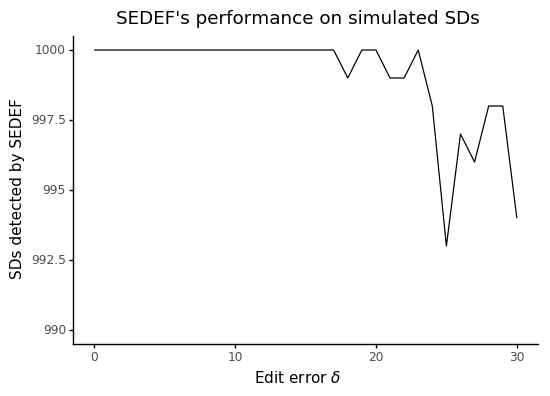

<ggplot: (285761481)>

In [7]:
import pandas as pd
from plotnine import *

df = pd.read_csv('output-rand.txt', sep=';', index_col=False)
(ggplot(df, aes(x='error', y='hits')) +
 geom_line() + 
 ylim(990,1000) +
 labs(x = u"Edit error $\delta$", y="SDs detected by SEDEF", title="SEDEF's performance on simulated SDs") +
 theme_classic() +
 theme(text=element_text(family=['Helvetica']))
)

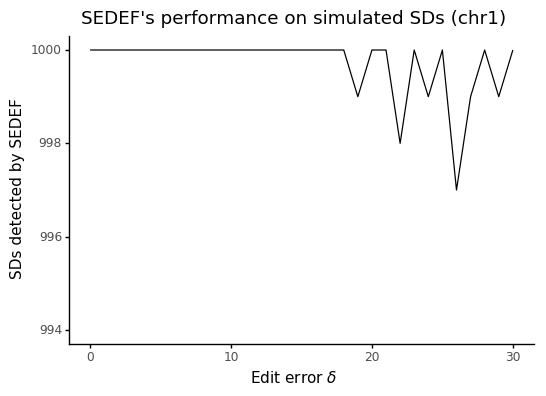

<ggplot: (285842817)>

In [6]:
df = pd.read_csv('output-chr1.txt', sep=';', index_col=False)
(ggplot(df, aes(x='error', y='hits')) +
 geom_line() + 
 ylim(994,1000) +
 labs(x = u"Edit error $\delta$", y="SDs detected by SEDEF", 
      title="SEDEF's performance on simulated SDs (chr1)") +
 theme_classic() +
 theme(text=element_text(family=['Helvetica']))
)